In [104]:
def modelCircle(b, c, d):
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])

  if abs(det) < 1.0e-10:
    return None

  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det

  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5

  return cx,cy,radius

def shrtDis(p,x,y,r):
    import numpy as np
    re= np.array(abs(((p[:,0]-x)**2+(p[:,1]-y)**2)**0.5-r))
    return re

In [105]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random. seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b =-1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )








#result = np.where(PO<1)


0.38207634421299774 55
0.37569242666144825 51
0 0


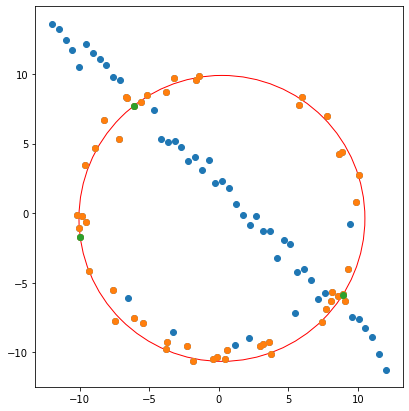

In [106]:
best=np.Infinity
v,m,R,ranL=0,0,0,[]

for i in range(400):
    #L=np.random.random_integers(0,99,size=3)
    L=np.random.choice(100, size=3, replace=False)
    
  
    x,y,r=modelCircle(X[L[0]],X[L[1]],X[L[2]])
    PO=shrtDis(X,x,y,r)
    if r>20:
        continue
    inliares=X[PO<1]
    if inliares.size>80:
        
        me=shrtDis(inliares,x,y,r)
        mean = sum(me/me.size)
        if mean < best:
            print(mean,me.size)
            best=mean
            ranL=L
            

x,y,r=modelCircle(X[ranL[0]],X[ranL[1]],X[ranL[2]])
PO=shrtDis(X,x,y,r)
bestInlier=X[PO<1]
fig,ax=plt.subplots(figsize=(7,7))

c=plt.Circle((x,y),r,fill=False)
c.set_color("r")
ax.set_aspect( 1 )
ax.add_artist( c )
ax.scatter(X[:,0],X[:,1])
ax.scatter(bestInlier[:,0],bestInlier[:,1])
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
ax.scatter(Y[:,0],Y[:,1])
print(v,m)



In [107]:
def ransac(Data,N,t,n):
    best=np.Infinity
    output=[]

    for i in range(N):
        rndPoints=np.random.choice(Data.size//2, size=3, replace=False)
        x,y,r=modelCircle(Data[rndPoints[0]],Data[rndPoints[1]],Data[rndPoints[2]])
        PO=shrtDis(Data,x,y,r)
        if r>max(Data[:,1])*1.5:
            continue
        inliares=Data[PO<t]
        if inliares.size/2>n:
            
            me=shrtDis(inliares,x,y,r)
            mean = sum(me/me.size)
            if mean < best:
               
                best=mean
                output=rndPoints
                inli=inliares
   
    return output,inli
def plotCiircle(Data,Datalst,color='r'):
    x,y,r=modelCircle(Datalst[Data[0]],Datalst[Data[1]],Datalst[Data[2]])
    c=plt.Circle((x,y),r,fill=False)
    c.set_color(color)
    return c


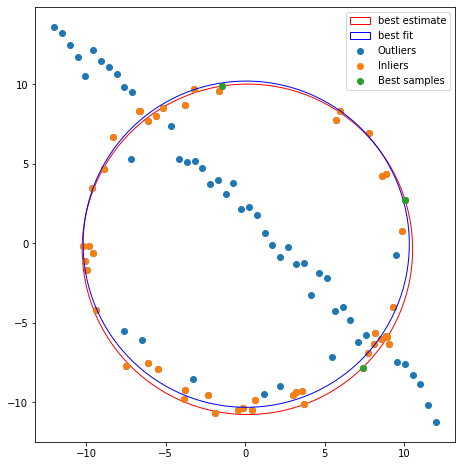

In [124]:
ranL,bestInlier=ransac(X,50,1,40)          
c=plotCiircle(ranL,X)
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( c )
p1=ax.scatter(X[:,0],X[:,1])
p2=ax.scatter(bestInlier[:,0],bestInlier[:,1])
bestfit,inl=ransac(bestInlier,50,1,bestInlier.size//2.2)
c2=plotCiircle(bestfit,bestInlier,'b')
ax.add_artist( c2 )
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
p3=ax.scatter(Y[:,0],Y[:,1])
plt.legend(handles=[c, c2,p1,p2,p3],labels=['best estimate','best fit','Outliers','Inliers','Best samples'])
plt.show()

In [126]:
def ransac2(Data,N,t,n):
    maxi=0
    output=np.array([])

    for i in range(N):
        rndPoints=np.random.choice(Data.size//2, size=3, replace=False)
        x,y,r=modelCircle(Data[rndPoints[0]],Data[rndPoints[1]],Data[rndPoints[2]])
        PO=shrtDis(Data,x,y,r)
        if r>max(Data[:,1])*1.5:
            continue
        inliares=Data[PO<t]
        if len(inliares)>n:
            
            
            
               
            me=shrtDis(inliares,x,y,r)
            mean = sum(me/me.size)
            if maxi < len(inliares):
               
                best=mean
                output=rndPoints
                inli=inliares
            elif maxi== len(inliares) and best>mean:
                best=mean
                output=rndPoints
                inli=inliares

                
    return output,inli

    

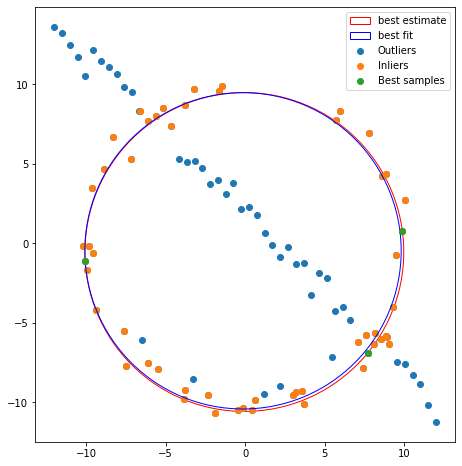

In [154]:
ranL,bestInlier=ransac2(X,500,1,40)          
c=plotCiircle(ranL,X)
fig,ax=plt.subplots(figsize=(8,8))
ax.set_aspect( 1 )
ax.add_artist( c )
p1=ax.scatter(X[:,0],X[:,1])
p2=ax.scatter(bestInlier[:,0],bestInlier[:,1])
bestfit,inl=ransac2(bestInlier,50,1,bestInlier.size//2.2)
c2=plotCiircle(bestfit,bestInlier,'b')
ax.add_artist( c2 )
Y=np.vstack((X[ranL[0]],X[ranL[1]],X[ranL[2]]))
p3=ax.scatter(Y[:,0],Y[:,1])
plt.legend(handles=[c, c2,p1,p2,p3],labels=['best estimate','best fit','Outliers','Inliers','Best samples'])
plt.show()

In [5]:
import numpy as np
np.linalg.eig(np.array([[3,1,-1],[2,2,-1],[2,2,0]]))

(array([2.00000005, 1.99999995, 1.        ]),
 array([[-4.08248297e-01,  4.08248284e-01,  4.47213595e-01],
        [-4.08248297e-01,  4.08248284e-01, -2.10650008e-16],
        [-8.16496575e-01,  8.16496587e-01,  8.94427191e-01]]))

(640, 800, 3)


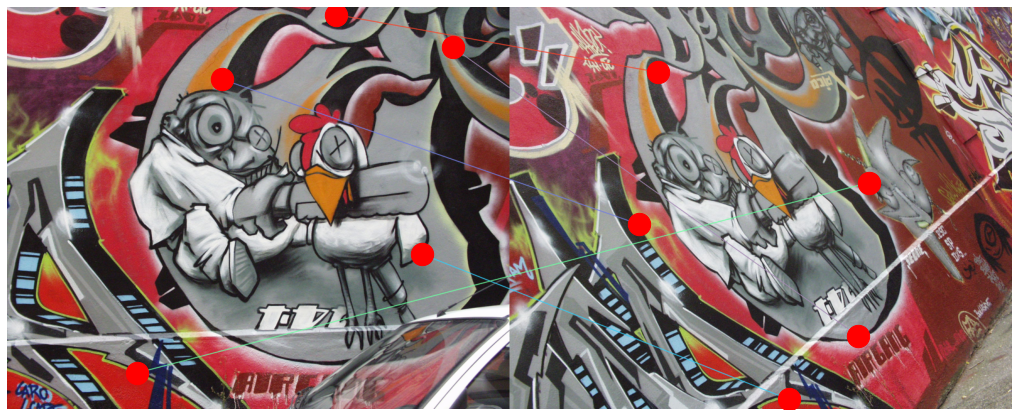

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

img1 = cv.imread(r"graf\img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"graf\img4.ppm", cv.IMREAD_COLOR)
print(img2.shape)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[50:55], None, flags =2)
fig, ax = plt.subplots(1,1, figsize = (18, 18))
plt.imshow(img3)
for i in range(50,55):
    plt.scatter(keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1], s=500, c='red', marker='o')
    plt.scatter(keypoints_2[matches[i].trainIdx].pt[0]+800, keypoints_2[matches[i].trainIdx].pt[1], s=500, c='red', marker='o')
plt.axis('off')
plt.show()


In [167]:
print(keypoints_1[matches[1].queryIdx].pt[0], keypoints_1[matches[1].queryIdx].pt[1])

# xs1,ys1=keypoints_1[matches[0].queryIdx].pt
# xs2,ys2=keypoints_1[matches[1].queryIdx].pt
# xs3,ys3=keypoints_1[matches[2].queryIdx].pt
# xs4,ys4=keypoints_1[matches[3].queryIdx].pt

# xd1,yd1=keypoints_2[matches[0].trainIdx].pt
# xd2,yd2=keypoints_2[matches[1].trainIdx].pt
# xd3,yd3=keypoints_2[matches[2].trainIdx].pt
# xd4,yd4=keypoints_2[matches[3].trainIdx].pt
xs1,ys1=keypoints_1[matches[0].trainIdx].pt
xs2,ys2=keypoints_1[matches[1].trainIdx].pt
xs3,ys3=keypoints_1[matches[2].trainIdx].pt
xs4,ys4=keypoints_1[matches[3].trainIdx].pt

xd1,yd1=keypoints_2[matches[0].queryIdx].pt
xd2,yd2=keypoints_2[matches[1].queryIdx].pt
xd3,yd3=keypoints_2[matches[2].queryIdx].pt
xd4,yd4=keypoints_2[matches[3].queryIdx].pt

A=np.array([[xs1,ys1,1,0,0,0,-xd1*xs1,-xd1*ys1,-xd1],[
    0,0,0,xs1,ys1,1,-yd1*xs1,-yd1*ys1,-yd1],
    [xs2,ys2,1,0,0,0,-xd2*xs2,-xd2*ys2,-xd2],
    [0,0,0,xs2,ys2,1,-yd2*xs2,-yd2*ys2,-yd2],
    [xs3,ys3,1,0,0,0,-xd3*xs3,-xd3*ys3,-xd3],
    [0,0,0,xs3,ys3,1,-yd3*xs3,-yd3*ys3,-yd3],
    [xs4,ys4,1,0,0,0,-xd4*xs4,-xd4*ys4,-xd4],
    [0,0,0,xs4,ys4,1,-yd4*xs4,-yd4*ys4,-yd4]]
    )

np.linalg.eig((A.T)@A)


564.5857543945312 439.66961669921875


(array([1.72387753e+11, 1.81805519e+10, 4.59053928e+05, 1.33482241e+05,
        9.18548535e+04, 1.45323355e+04, 1.93029030e+03, 9.80015135e-02,
        3.14463950e-09]),
 array([[ 7.48260205e-04, -1.18414554e-03, -3.56686577e-01,
         -1.23438489e-01, -1.09573278e-01, -8.48227182e-01,
          3.54981448e-01, -5.29520839e-03,  3.73479874e-04],
        [ 8.68951991e-04, -4.90707993e-04, -5.50605249e-01,
         -1.65674711e-01,  7.87236608e-01,  6.47366733e-02,
         -2.13185372e-01, -4.18177184e-04,  2.06448100e-03],
        [ 3.11326934e-06, -2.26990235e-06, -1.80251769e-03,
          5.59981182e-04,  2.41075873e-03, -2.55058082e-03,
          3.88019408e-03,  6.75143716e-01, -7.37665253e-01],
        [ 5.27237626e-04, -6.57433957e-04,  4.90938468e-01,
         -1.97371755e-01,  4.85655483e-01,  5.00104167e-02,
          6.94003592e-01, -4.43904395e-03, -3.47485580e-04],
        [ 8.92169258e-04,  1.39022514e-03,  5.63789134e-01,
         -2.38486468e-01,  2.23943967e-01, -4.

((-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 799.5, -0.5))

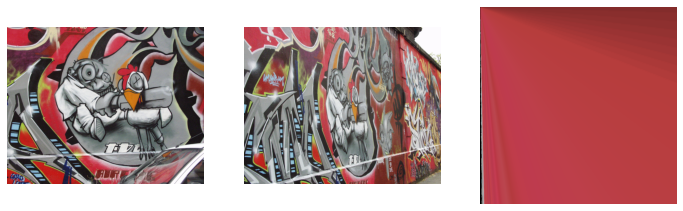

In [171]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

im1 = cv.imread(r"./graf/img1.ppm",cv.IMREAD_ANYCOLOR)
im4 = cv.imread(r"./graf/img5.ppm",cv.IMREAD_ANYCOLOR)
im1=cv.cvtColor(im1,cv.COLOR_BGR2RGB)
im4=cv.cvtColor(im4,cv.COLOR_BGR2RGB)

H=np.array([[ 5.27237626e-04, -6.57433957e-04,  4.90938468e-01],
         [-1.97371755e-01,  4.85655483e-01,  5.00104167e-02],
          [6.94003592e-01, -4.43904395e-03, -3.47485580e-04]])

H=H*1.33482241e+05
imlto4 = cv.warpPerspective(im4,np.linalg.inv(H),(800,800))

fig,ax =plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(im1)
ax[1].imshow(im4)
ax[2].imshow(imlto4)
ax[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')


((-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 639.5, -0.5),
 (-0.5, 799.5, 799.5, -0.5))

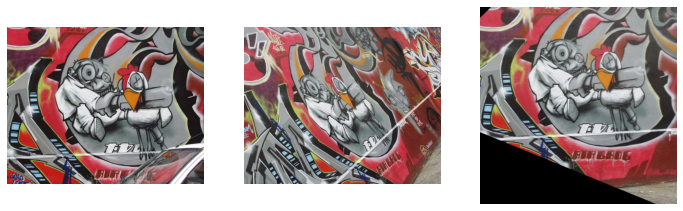

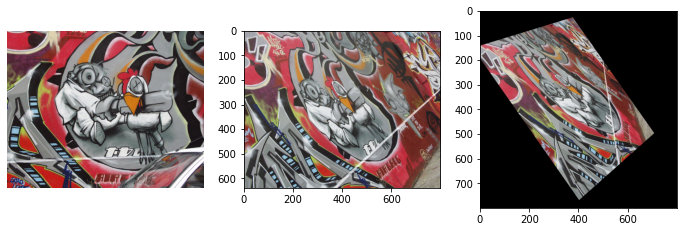

In [225]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

im1 = cv.imread(r"./graf/img1.ppm",cv.IMREAD_ANYCOLOR)
im4 = cv.imread(r"./graf/img4.ppm",cv.IMREAD_ANYCOLOR)
im1=cv.cvtColor(im1,cv.COLOR_BGR2RGB)
im4=cv.cvtColor(im4,cv.COLOR_BGR2RGB)

H=np.array([[ 6.53647218e-01 , 6.72297042e-01,-2.94420290e+01],
 [-1.45478078e-01 , 9.59718405e-01,  1.49517458e+02],
 [ 3.88030027e-04 ,-7.71971384e-06 , 1.00000000e+00]])

imlto4 = cv.warpPerspective(im4,np.linalg.inv(H),(800,800))

fig,ax =plt.subplots(1,3,figsize=(12,12))
ax[0].imshow(im1)
ax[1].imshow(im4)
ax[2].imshow(imlto4)
ax[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')
imlto4 = cv.warpPerspective(im4,H,(800,800))

fig2,ax2 =plt.subplots(1,3,figsize=(12,12))
ax2[0].imshow(im1)
ax2[1].imshow(im4)
ax2[2].imshow(imlto4)
ax2[0].axis('off'),ax[1].axis('off'),ax[2].axis('off')


In [219]:
A = []
ccp=[[243,195],[451,515],[164,200],[684,107]]
ppc=[[347,228],[444,558],[312,233],[494,190]]
for i in range(0, len(matches[:4])):
    u, v = ppc[i][0],ppc[i][1]
    x, y = ccp[i][0],ccp[i][0]
    A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
    A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
A = np.asarray(A)
U, S, Vh = np.linalg.svd(A)
L = Vh[-1,:] / Vh[-1,-1]
H = L.reshape(3, 3)
H

array([[ 3.63927068e+01, -1.14534366e+01, -2.20243129e+00],
       [ 3.55901419e+03, -3.55707432e+03,  1.98804807e+00],
       [ 1.54196810e+17, -1.54196810e+17,  1.00000000e+00]])

In [228]:
import cv2
import numpy as np
import getopt
import sys
import random
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.matrix(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h


#
#Calculate the geometric distance between estimated points and original points
#
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


#
#Runs through ransac algorithm, creating homographies from random correspondences
#
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []

        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        print ("Corr size: ", len(corr), " NumInliers: ", len(inliers), "Max inliers: ", len(maxInliers))

        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers



In [230]:


#find features and keypoints
correspondenceList = []
img1 = cv.imread(r"graf\img1.ppm", cv.IMREAD_COLOR)
img2 = cv.imread(r"graf\img4.ppm", cv.IMREAD_COLOR)
print(img2.shape)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1, None) 
keypoints_2, descriptors_2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_L1, crossCheck = True)

matches = bf.match(descriptors_1, descriptors_2)
for match in matches:
    (x1, y1) = keypoints_1[match.queryIdx].pt
    (x2, y2) = keypoints_2[match.trainIdx].pt
    

    corrs = np.matrix(correspondenceList)

        #run ransac algorithm
    finalH, inliers = ransac(corrs, 0.3)

(640, 800, 3)


IndexError: index 0 is out of bounds for size 0